In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import timezone

from math import cos, radians
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_color(cluster):
    if cluster == 1:
        return 'lime'
    if cluster == 2:
        return 'brown'
    if cluster == 3:
        return 'orange'
    if cluster == 4:
        return 'green'
    if cluster == 5:
        return 'cyan'
    if cluster == 6:
        return 'darkviolet'

In [3]:
# no sign for lat because of 'N'
# no sign for lon because of 'E'
def dms2dd(as_string):
    degrees = int(as_string[:2])
    minutes = int(as_string[2:4])
    seconds = float(as_string[4:8])
    lat_dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    degrees = 1*int(as_string[11:14])
    minutes = 1*int(as_string[14:16])
    seconds = 1*float(as_string[16:21])
    lon_dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);

    return lat_dd, lon_dd;

In [4]:
# Runway 01L end COORD
# 601257.84N 0110529.99E
    
# Runway 19R end COORD
# 601106.00N 0110425.48E
    
# Runway 01R end COORD
# 601204.35N 0110720.95E
    
# Runway 19L end COORD
# 601032.72N 0110628.02E
    
rwy01L_end_lat, rwy01L_end_lon = dms2dd("601257.84N 0110529.99E")

rwy19R_end_lat, rwy19R_end_lon = dms2dd("601106.00N 0110425.48E")

rwy01R_end_lat, rwy01R_end_lon = dms2dd("601204.35N 0110720.95E")

rwy19L_end_lat, rwy19L_end_lon = dms2dd("601032.72N 0110628.02E")

print(rwy01L_end_lat, rwy01L_end_lon)
print(rwy19R_end_lat, rwy19R_end_lon)
print(rwy01R_end_lat, rwy01R_end_lon)
print(rwy19L_end_lat, rwy19L_end_lon)

60.216055555555556 11.09166388888889
60.184999999999995 11.073744444444444
60.20119444444445 11.122486111111112
60.17575 11.107783333333334


In [5]:
TMA_lon=[9.59556, 11.7944, 11.8494, 12.0989, 12.3611, 12.3394, 12.3417, 12.2917, 11.8292, 11.6958, 11.0722, 10.95, 10.5583, 10.1, 9.59556];

TMA_lat=[59.7097, 59.3667, 59.8333, 59.8906, 60.2236, 60.4039, 60.5, 60.7125, 60.875, 60.7972, 60.8778, 60.9389, 60.925, 60.7292, 59.7097];


central_lat = min(TMA_lat) + (max(TMA_lat)-min(TMA_lat))/2
central_lon = min(TMA_lon) + (max(TMA_lon)-min(TMA_lon))/2

def plot_TMA_ENGM(ax):
       
    rwy01L_lon=[rwy19R_end_lon, rwy01L_end_lon];
    rwy01L_lat=[rwy19R_end_lat, rwy01L_end_lat];

    rwy19R_lon=[rwy01L_end_lon, rwy19R_end_lon];
    rwy19R_lat=[rwy01L_end_lat, rwy19R_end_lat];

    rwy01R_lon=[rwy19L_end_lon, rwy01R_end_lon];
    rwy01R_lat=[rwy19L_end_lat, rwy01R_end_lat];

    rwy19L_lon=[rwy01R_end_lon, rwy19L_end_lon];
    rwy19L_lat=[rwy01R_end_lat, rwy19L_end_lat];

    plt.plot(TMA_lon, TMA_lat, color="blue")
    plt.plot(rwy01L_lon, rwy01L_lat, color="red")
    plt.plot(rwy01R_lon, rwy01R_lat, color="red")

In [6]:
def plot_legend(number_of_clusters):
    handles = []
    for i in range(0, number_of_clusters):
        cluster_color = get_color(i+1)
        color_patch = mpatches.Patch(color=cluster_color, label='cluster ' + str(i+1))
        handles += [color_patch]
    plt.legend(handles=handles, fontsize=10, loc="best")

In [7]:
def plot_horizontal_profile_ENGM_clustering(df, runway, linewidth, number_of_clusters, clustering_df):
    
    fig, ax = plt.subplots(1, 1,figsize=(10,10))
    
    # calculate the aspect ratio that will approximate a 
    # Mercator projection at this central latitude 
    mercator_aspect_ratio = 1/cos(radians(central_lat))

    # set the aspect ratio of the axes to that
    ax.set_aspect(mercator_aspect_ratio)

    plt.xlabel('Longitude', fontsize=25)
    plt.ylabel('Latitude', fontsize=25)  
    
    plt.tick_params(labelsize=15)
    
    plot_TMA_ENGM(ax)
    
    if df.empty:
        return
    
    for flight_id, new_df in df.groupby(level='flightId'):
        flight_states_opensky_df = df.loc[(flight_id,), :]
        lon = []
        lat = []
        for seq, row in flight_states_opensky_df.groupby(level='sequence'):
        
            if len(row['lon']) == 1:
                lon.append(row['lon'].item())
            if len(row['lat']) == 1:
                lat.append(row['lat'].item())
            
        cluster_color = get_color(clustering_df.loc[flight_id]['cluster'])
        plt.plot(lon, lat, color = cluster_color, linewidth=linewidth)

        plt.plot(clustering_df.loc[flight_id]['center_lon'], clustering_df.loc[flight_id]['center_lat'], 'ro')
        
    
    plot_legend(number_of_clusters)

# Data uploading

In [8]:
filename = "../data/ENGM/Datasets/PM_final_NORTH.csv"
dataset_PM_north_df = pd.read_csv(filename, sep=' ',
    names = ['flightId', 'sequence', 'timestamp', 'lat', 'lon', 'rawAltitude', 'altitude', 'velocity', 'beginDate', 'endDate'])
dataset_PM_north_df.set_index(['flightId', 'sequence'], inplace = True)

number_of_clusters = 6
filename = "../data/ENGM/Clustering/PM_final_NORTH_clusters_" + str(number_of_clusters) + ".csv"
dataset_PM_north_clusters_df = pd.read_csv(filename, sep=' ')
dataset_PM_north_clusters_df.set_index(['flight_id'], inplace=True)

In [9]:
filename = "../data/ENGM/Datasets/PM_final_SOUTH.csv"
dataset_PM_south_df = pd.read_csv(filename, sep=' ',
    names = ['flightId', 'sequence', 'timestamp', 'lat', 'lon', 'rawAltitude', 'altitude', 'velocity', 'beginDate', 'endDate'])
dataset_PM_south_df.set_index(['flightId', 'sequence'], inplace = True)

number_of_clusters = 6
filename = "../data/ENGM/Clustering/PM_final_SOUTH_clusters_" + str(number_of_clusters) + ".csv"
dataset_PM_south_clusters_df = pd.read_csv(filename, sep=' ')
dataset_PM_south_clusters_df.set_index(['flight_id'], inplace=True)

In [10]:
filename = "../data/ENGM/Datasets/nonPM_final_NORTH.csv"
dataset_nonPM_north_df = pd.read_csv(filename, sep=' ',
    names = ['flightId', 'sequence', 'timestamp', 'lat', 'lon', 'rawAltitude', 'altitude', 'velocity', 'beginDate', 'endDate'])
dataset_nonPM_north_df.set_index(['flightId', 'sequence'], inplace = True)

number_of_clusters = 6
filename = "../data/ENGM/Clustering/nonPM_final_NORTH_clusters_" + str(number_of_clusters) + ".csv"
dataset_nonPM_north_clusters_df = pd.read_csv(filename, sep=' ')
dataset_nonPM_north_clusters_df.set_index(['flight_id'], inplace=True)

In [11]:
filename = "../data/ENGM/Datasets/nonPM_final_SOUTH.csv"
dataset_nonPM_south_df = pd.read_csv(filename, sep=' ',
    names = ['flightId', 'sequence', 'timestamp', 'lat', 'lon', 'rawAltitude', 'altitude', 'velocity', 'beginDate', 'endDate'])
dataset_nonPM_south_df.set_index(['flightId', 'sequence'], inplace = True)

number_of_clusters = 6
filename = "../data/ENGM/Clustering/nonPM_final_SOUTH_clusters_" + str(number_of_clusters) + ".csv"
dataset_nonPM_south_clusters_df = pd.read_csv(filename, sep=' ')
dataset_nonPM_south_clusters_df.set_index(['flight_id'], inplace=True)

In [12]:
filename = "../data/ENGM/Datasets/TT_NORTH.csv"
dataset_TT_north_df = pd.read_csv(filename, sep=' ',
    names = ['flightId', 'sequence', 'timestamp', 'lat', 'lon', 'rawAltitude', 'altitude', 'velocity', 'beginDate', 'endDate'])
dataset_TT_north_df.set_index(['flightId', 'sequence'], inplace = True)

number_of_clusters = 6
filename = "../data/ENGM/Clustering/TT_NORTH_clusters_" + str(number_of_clusters) + ".csv"
dataset_TT_north_clusters_df = pd.read_csv(filename, sep=' ')
dataset_TT_north_clusters_df.set_index(['flight_id'], inplace=True)

In [13]:
filename = "../data/ENGM/Datasets/TT_SOUTH.csv"
dataset_TT_south_df = pd.read_csv(filename, sep=' ',
    names = ['flightId', 'sequence', 'timestamp', 'lat', 'lon', 'rawAltitude', 'altitude', 'velocity', 'beginDate', 'endDate'])
dataset_TT_south_df.set_index(['flightId', 'sequence'], inplace = True)

number_of_clusters = 6
filename = "../data/ENGM/Clustering/TT_SOUTH_clusters_" + str(number_of_clusters) + ".csv"
dataset_TT_south_clusters_df = pd.read_csv(filename, sep=' ')
dataset_TT_south_clusters_df.set_index(['flight_id'], inplace=True)

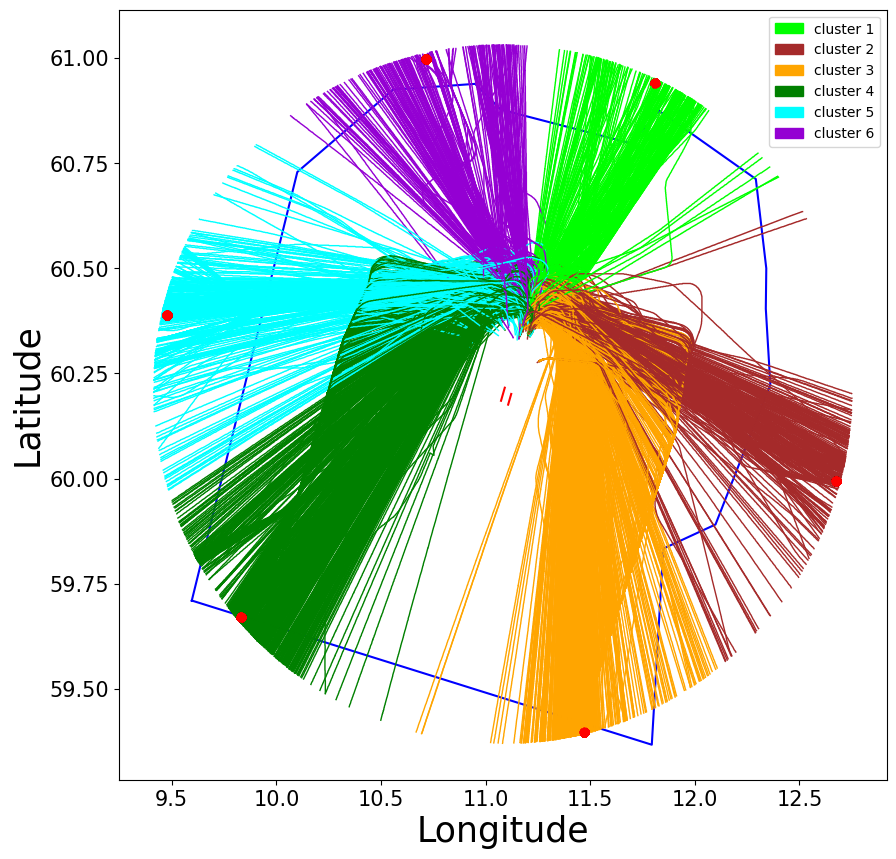

In [14]:
plot_horizontal_profile_ENGM_clustering(dataset_nonPM_north_df, 'x', 1, number_of_clusters, dataset_nonPM_north_clusters_df)

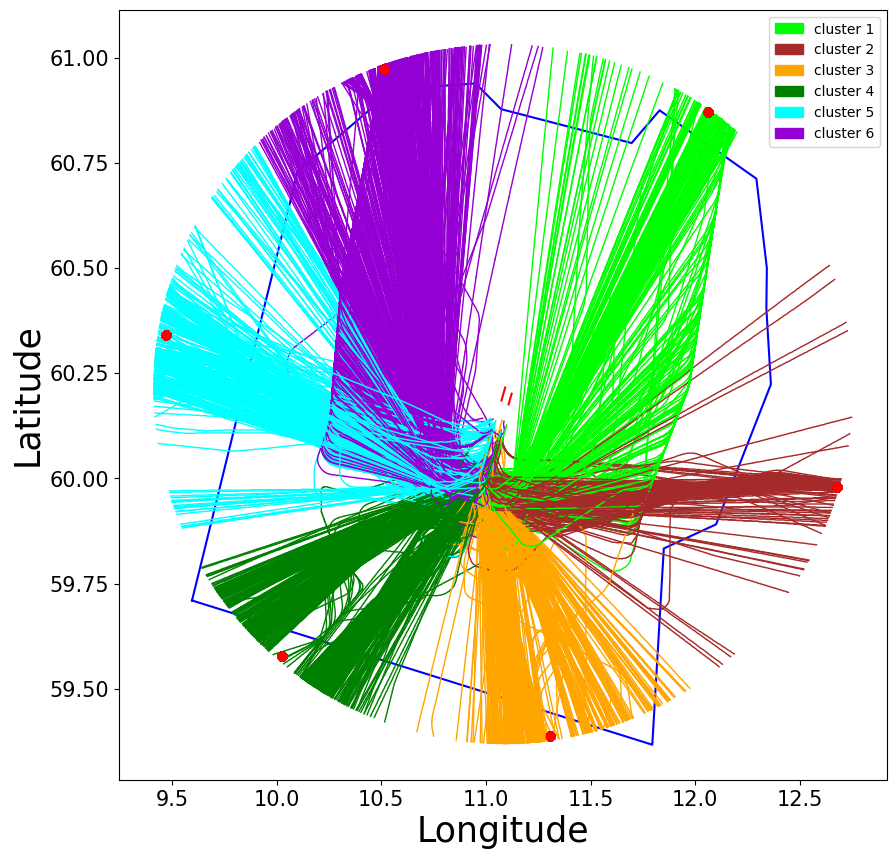

In [15]:
plot_horizontal_profile_ENGM_clustering(dataset_nonPM_south_df, 'x', 1, number_of_clusters, dataset_nonPM_south_clusters_df)

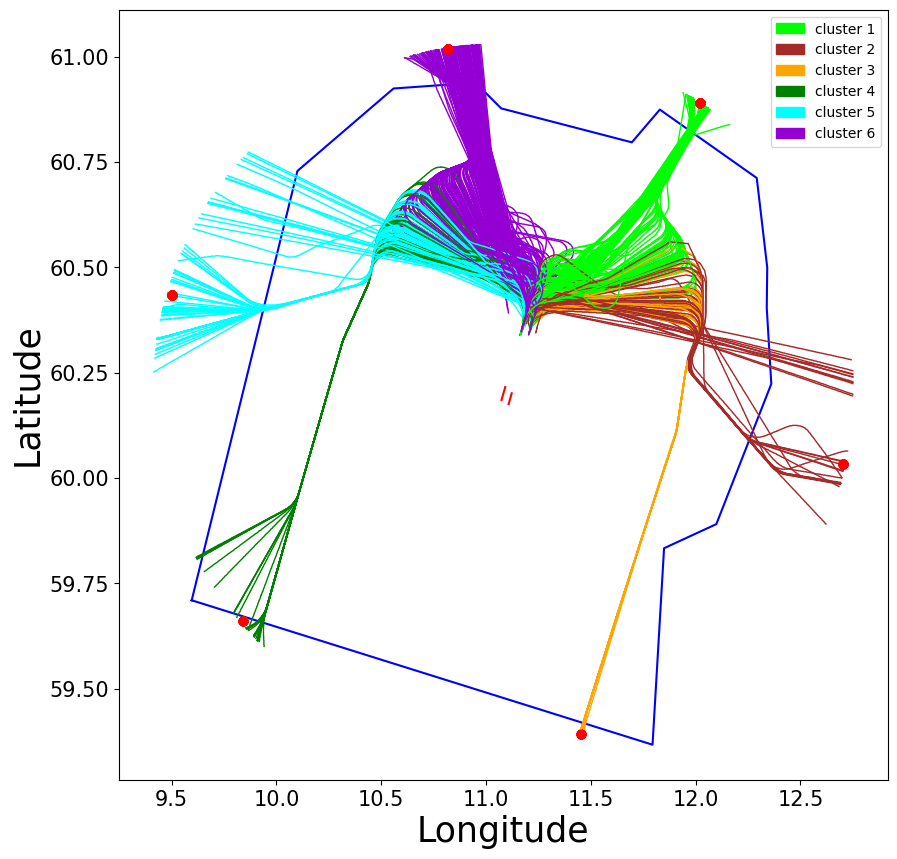

In [16]:
plot_horizontal_profile_ENGM_clustering(dataset_PM_north_df, 'x', 1, number_of_clusters, dataset_PM_north_clusters_df)

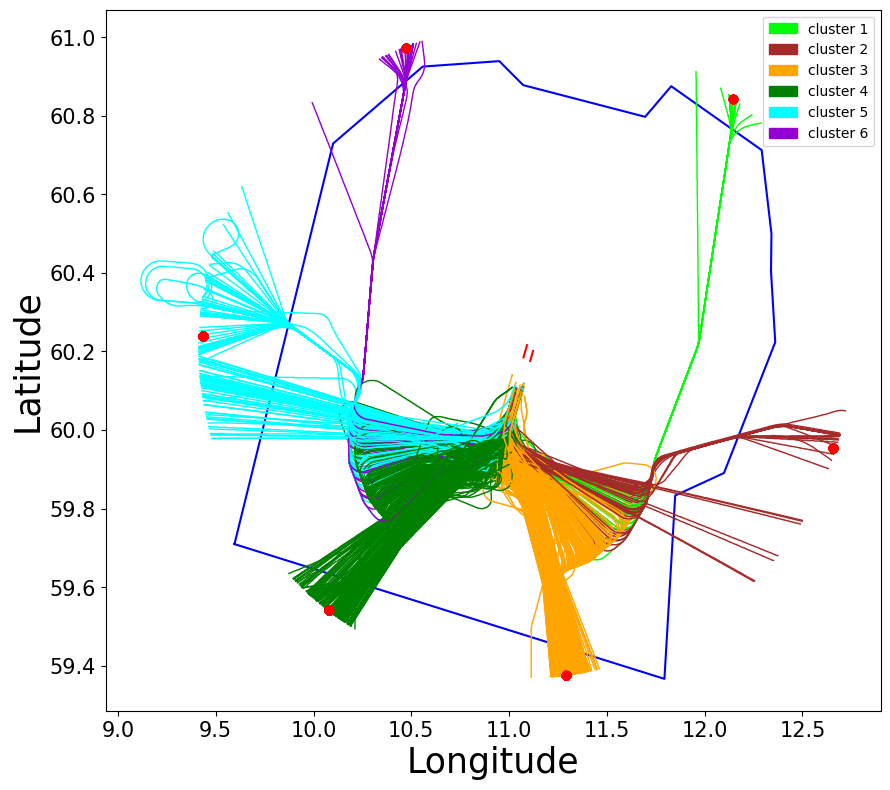

In [17]:
plot_horizontal_profile_ENGM_clustering(dataset_PM_south_df, 'x', 1, number_of_clusters, dataset_PM_south_clusters_df)

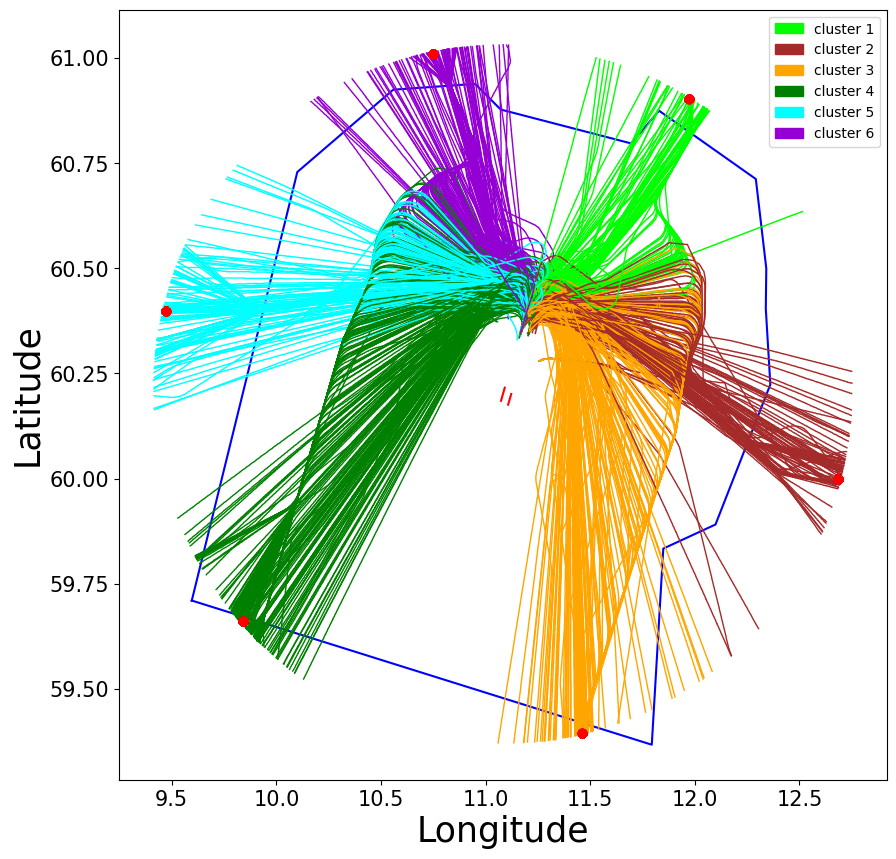

In [18]:
plot_horizontal_profile_ENGM_clustering(dataset_TT_north_df, 'x', 1, number_of_clusters, dataset_TT_north_clusters_df)

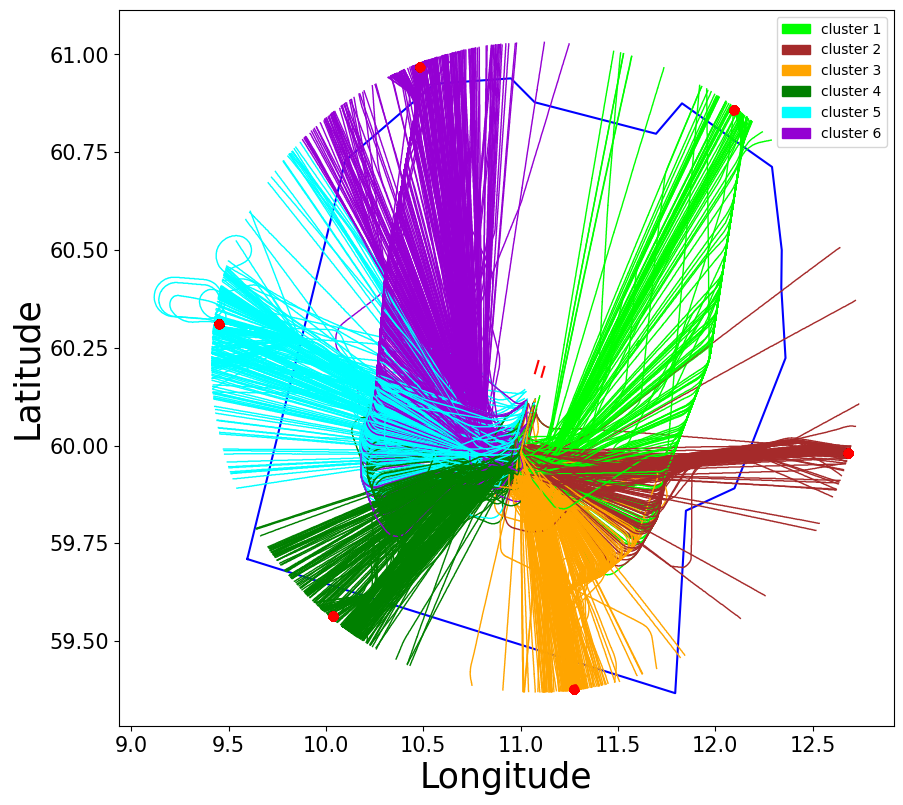

In [19]:
plot_horizontal_profile_ENGM_clustering(dataset_TT_south_df, 'x', 1, number_of_clusters, dataset_TT_south_clusters_df)